# Load Data

In [1]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 100

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm
from utils import *

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 6
    train_folds = [0, ] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 20
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 1000
    frozen_layers = 0

In [ ]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

In [5]:
device = torch.device(CFG.device)

# Dataset

In [21]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [22]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    v2.RandomRotation(degrees=(0, 90)),  # Random rotation between 0 and 360 degrees
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [23]:
os.listdir(TEST_DATA_FOLDER )

['DR2', 'Normal', 'DR3', 'DR1']

In [31]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder


0


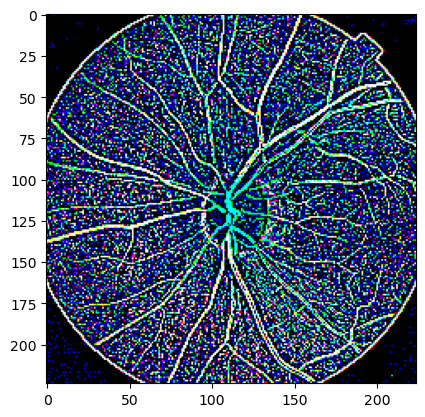

In [32]:
# visualize the transformations
test_data = ImageFolder(TEST_DATA_FOLDER, transform=val_transforms)
image, label = test_data[10]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)
print(label)

In [33]:
test_data.class_to_idx

{'DR1': 0, 'DR2': 1, 'DR3': 2, 'Normal': 3}

# Metric

In [61]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

# Train and evaluate functions

In [35]:
def evaluate_model(cfg, feature_extractor, model, data_loader, epoch=-1):
    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)
            
            features = feature_extractor(images)
            logits = model(features)
            
            targets.append(target.detach().cpu())
            predictions.append(logits.detach().cpu())
            del images, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)

    # base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    try:
        wandb.log({"roc": wandb.plot.roc_curve(targets.numpy(), probabilities.numpy())})
        roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')
        
        wandb.log({"pr": wandb.plot.pr_curve(targets.numpy(), probabilities.numpy())})
        
    except:
        roc_auc = 0

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return roc_auc, accuracy, precision

In [36]:
class LinearClassifier(nn.Module):
    def __init__(self, in_features=2048, num_classes=NUM_CLASSES):
        super().__init__()
        self.model = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    

class SupConModel(nn.Module):
    def __init__(self, encoder, input_dim=2048, output_dim=128):        # assuming either resnet50 or resnet101 is used
        super().__init__()
        self.encoder = encoder
        self.head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        ft = self.encoder(x)
        return F.normalize(self.head(ft), dim=1)


def create_model():
    # get the feature extractor
    resnet = timm.create_model(CFG.model_name, num_classes=0, pretrained=False)
    feature_extractor = SupConModel(resnet)
    feature_extractor.load_state_dict(torch.load(OUTPUT_FOLDER + 'ckpt_epoch_8.pth'))
    
    # remove the projection head
    feature_extractor = nn.Sequential(*list(feature_extractor.children())[:-1])

    # create a simple linear classifier
    classifier = LinearClassifier()
    classifier.load_state_dict(torch.load(OUTPUT_FOLDER + 'lc_sclr_11.pth'))
    return feature_extractor.to(device), classifier.to(device)

In [70]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()
    
    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # # store the embeddings for future use
    # torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    # torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


## Train folds

In [71]:
seed_everything(CFG.seed)

test_loader = DataLoader(
    test_data,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.workers,
    pin_memory=True,
    drop_last=False,
)

# PREPARE MODEL, OPTIMIZER AND SCHEDULER
feature_extractor, model = create_model()
feature_extractor.eval()
model.eval()

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader))

loss_criterion = nn.CrossEntropyLoss()

# TRAIN FOLD
best_score = 0

wandb.run.tags = [f"fold_{FOLD}"]

for epoch in range(0, CFG.epochs):
    train_loss, train_lr, train_auc, train_accuracy, train_precision = train_epoch(CFG, model, train_loader, loss_criterion, optimizer, scheduler, epoch)

    val_loss, val_auc, val_accuracy, val_precision = evaluate_model(CFG, model, valid_loader, loss_criterion, epoch)
    
    # Log metrics to wandb
    wandb.log({
        'train_loss': train_loss,
        'train_auc': train_auc,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'val_loss': val_loss,
        'val_auc': val_auc,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'learning_rate': train_lr[-1]  # Log the last learning rate of the epoch
    })

    if (val_accuracy > best_score):
        print(f"{style.GREEN}New best score: {best_score:.4f} -> {val_accuracy:.4f}{style.END}")
        best_score = val_accuracy
        torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth'))
        

# plot a tsne plot of all the images using embeddings from the model
loader = DataLoader(
    test_data,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.workers,
    pin_memory=True,
    drop_last=False,
)

features, targets = get_embeddings(feature_extractor, loader)
plot_tsne(features, targets)

Layer conv1 is trainable.
Layer bn1 is trainable.
Layer act1 is trainable.
Layer maxpool is trainable.
Layer layer1 is trainable.
Layer layer2 is trainable.
Layer layer3 is trainable.
Layer layer4 is trainable.
Layer global_pool is trainable.
Layer fc is trainable.
Model parameters: 23_518_277


Epoch 0 training 20/20 [LR 0.004969] - loss: 1.6485: 100%|███████████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch 0: training loss = 1.6485 auc = 0.4868 accuracy = 0.2150 precision = 0.2188


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Epoch 0: validation loss = 1.6251 auc = 0.0000 accuracy = 0.2143 precision = 0.0940
New best score: 0.0000 -> 0.2143


/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 1 training 20/20 [LR 0.004878] - loss: 1.5778: 100%|███████████████| 20/20 [00:21<00:00,  1.06s/it]


Epoch 1: training loss = 1.5778 auc = 0.5908 accuracy = 0.2550 precision = 0.2785


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 1: validation loss = 1.6735 auc = 0.0000 accuracy = 0.2619 precision = 0.3811
New best score: 0.2143 -> 0.2619


Epoch 2 training 20/20 [LR 0.004728] - loss: 1.5015: 100%|███████████████| 20/20 [00:21<00:00,  1.05s/it]

Epoch 2: training loss = 1.5015 auc = 0.6787 accuracy = 0.3000 precision = 0.2893



100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 2: validation loss = 2.1124 auc = 0.0000 accuracy = 0.2619 precision = 0.2526


/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 3 training 20/20 [LR 0.004523] - loss: 1.3510: 100%|███████████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 3: training loss = 1.3510 auc = 0.7412 accuracy = 0.3800 precision = 0.3749


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Epoch 3: validation loss = 2.7870 auc = 0.0000 accuracy = 0.2143 precision = 0.1909


Epoch 4 training 20/20 [LR 0.004268] - loss: 1.3476: 100%|███████████████| 20/20 [00:21<00:00,  1.06s/it]


Epoch 4: training loss = 1.3476 auc = 0.7447 accuracy = 0.3550 precision = 0.3476


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 4: validation loss = 3.1248 auc = 0.0000 accuracy = 0.2381 precision = 0.1518


/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 5 training 20/20 [LR 0.003970] - loss: 1.3567: 100%|███████████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 5: training loss = 1.3567 auc = 0.7494 accuracy = 0.3750 precision = 0.3971


100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


Epoch 5: validation loss = 2.2044 auc = 0.0000 accuracy = 0.2143 precision = 0.1821


Epoch 6 training 20/20 [LR 0.003635] - loss: 1.4598: 100%|███████████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 6: training loss = 1.4598 auc = 0.6979 accuracy = 0.3350 precision = 0.3336


  0%|                                                                              | 0/5 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
wandb.finish()